<a href="https://colab.research.google.com/github/sungkim11/forecast-stock-price/blob/main/Predict_Stock_Price_Orbit_1day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Stock Price Using Orbit

## 1. Prerequisites

Following are prerequisite for this tutorial:
- Stock Price Data
- Python Package: Uber Orbit
- Python Package: pandas-datareader


### 1.1. Stock Price Data

Daily Stock Price Data is sourced from Yahoo using pandas-datareader.

### 1.2. Python Packages

#### 1.2.1. Update pandas-datareader 

It seems if you are using Google Colab, you will need to update pandas-datareader package every single time.

In [2]:
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 109 kB 5.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


#### 1.2.2. Install Uber Orbit

It seems if you are using Google Colab, you will need to install orbit-ml package every single time then RESTART RUNTIME then install orbit-ml package again.

In [1]:
!pip install orbit-ml

## 2. Code

### 2.1. Import Python Packages

Import python packages and show its version. Showing version is important since it will enable other users to replicate your work using same python version and python packages version.

In [2]:
import pandas as pd
import matplotlib as plt
import platform

import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

import pandas_datareader
from pandas_datareader import data as web

import orbit
#from orbit.models import DLT
from orbit.models import LGT
from orbit.diagnostics.plot import plot_predicted_data,plot_predicted_components, plot_bt_predictions
from orbit.diagnostics.backtest import BackTester, TimeSeriesSplitter
from orbit.diagnostics.metrics import smape, wmape

print('Python: ', platform.python_version())
print('pandas: ', pd.__version__)
print('matplotlib: ', plt.__version__)
print('statsmodels: ', statsmodels.__version__)
print('pandas_datareader: ', pandas_datareader.__version__)
print('Orbit: ', orbit.__version__)

Python:  3.7.13
pandas:  1.3.5
matplotlib:  3.5.1
statsmodels:  0.13.2
pandas_datareader:  0.10.0
Orbit:  1.1.2


### 2.2. Import Stock Price Data from Yahoo Finance

We will be forecasting stock price of AMD where we will use NASDAQ price or QQQ as a regressor.

We will be pulling 2 years of stock price data of both AMD and QQQ where we will use first 12 months of stock price data to train the model and second 12 months of stock price data to test and validate the model performance.

In [3]:
twenty_four_months = date.today() + relativedelta(months=-24)

stock_price = web.DataReader('AMD', 'yahoo', twenty_four_months)
stock_price.reset_index(inplace=True)
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       505 non-null    datetime64[ns]
 1   High       505 non-null    float64       
 2   Low        505 non-null    float64       
 3   Open       505 non-null    float64       
 4   Close      505 non-null    float64       
 5   Volume     505 non-null    int64         
 6   Adj Close  505 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 27.7 KB


In [4]:
nasdaq_price = web.DataReader('QQQ', 'yahoo', twenty_four_months)
nasdaq_price.reset_index(inplace=True)
nasdaq_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       505 non-null    datetime64[ns]
 1   High       505 non-null    float64       
 2   Low        505 non-null    float64       
 3   Open       505 non-null    float64       
 4   Close      505 non-null    float64       
 5   Volume     505 non-null    float64       
 6   Adj Close  505 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 27.7 KB


### 2.3. Prep Stock Price Data

To simplify the data prep steps, we will drop columns we will not use from nasdaq_price dataframe as well as rename 'Adj Close' to 'nadaq' since stock_price dataframe also has 'Adj Close' column name.

In [5]:
nasdaq_price = nasdaq_price[['Date', 'Adj Close']]
nasdaq_price.rename(columns={'Adj Close': 'nasdaq'}, inplace=True)
nasdaq_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    505 non-null    datetime64[ns]
 1   nasdaq  505 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


We will join both stock_price dataframe and nasdaq_price dataframe using 'Date'

In [6]:
stock_price = pd.merge(stock_price, nasdaq_price, on='Date', how="left")
stock_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 504
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       505 non-null    datetime64[ns]
 1   High       505 non-null    float64       
 2   Low        505 non-null    float64       
 3   Open       505 non-null    float64       
 4   Close      505 non-null    float64       
 5   Volume     505 non-null    int64         
 6   Adj Close  505 non-null    float64       
 7   nasdaq     505 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 35.5 KB


We will name 'Adj Close' to 'adj_close' since I really do not like to having a space in column name.

In [7]:
stock_price.rename(columns={'Adj Close': 'adj_close'}, inplace=True)
stock_price.head(5)

,Date,High,Low,Open,Close,Volume,adj_close,nasdaq
0,2020-04-30,54.290001,52.029999,53.430000,52.389999,65543900,52.389999,216.820694
1,2020-05-01,51.950001,49.090000,51.070000,49.880001,69562700,49.880001,210.709595
2,2020-05-04,52.610001,49.730000,49.820000,52.560001,62590600,52.560001,213.165894
3,2020-05-05,53.509998,51.290001,53.430000,52.189999,56560500,52.189999,215.582642
4,2020-05-06,53.310001,51.880001,52.419998,52.160000,48138100,52.160000,216.909836


Let's split the dataset evenly to both train and test:
- train dataset
- test dataset

In [8]:
stock_price_train = stock_price[:-253]
stock_price_test = stock_price[-253:]

print('Train: ', stock_price_train.shape)
print('Test: ', stock_price_test.shape)

Train:  (252, 8)
Test:  (253, 8)


### 2.4. Develop Forecast Model

We will use Local Global Trend (LGT) with Markov Chain Monte Carlo (MCMC) sampling with point estimate.

In [11]:
%%time
stock_price_lgt = LGT(
  response_col='adj_close', 
  date_col='Date',  
  estimator='stan-mcmc',
  regressor_col=['nasdaq'],
  seed=8898,
  num_warmup=500,
  num_sample=1000,
  n_bootstrap_draws=100,
  prediction_percentiles=[10, 90],
)
stock_price_lgt.fit(df=stock_price_train) #, point_method='mean')

/usr/local/lib/python3.7/dist-packages/orbit/forecaster/forecaster.py:292: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 2.89 s, sys: 640 ms, total: 3.53 s
Wall time: 7min 57s


In [12]:
stock_price_predicted = stock_price_lgt.predict(df=stock_price_test, decompose=True) #, point_method='mean')

/usr/local/lib/python3.7/dist-packages/orbit/forecaster/forecaster.py:337: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


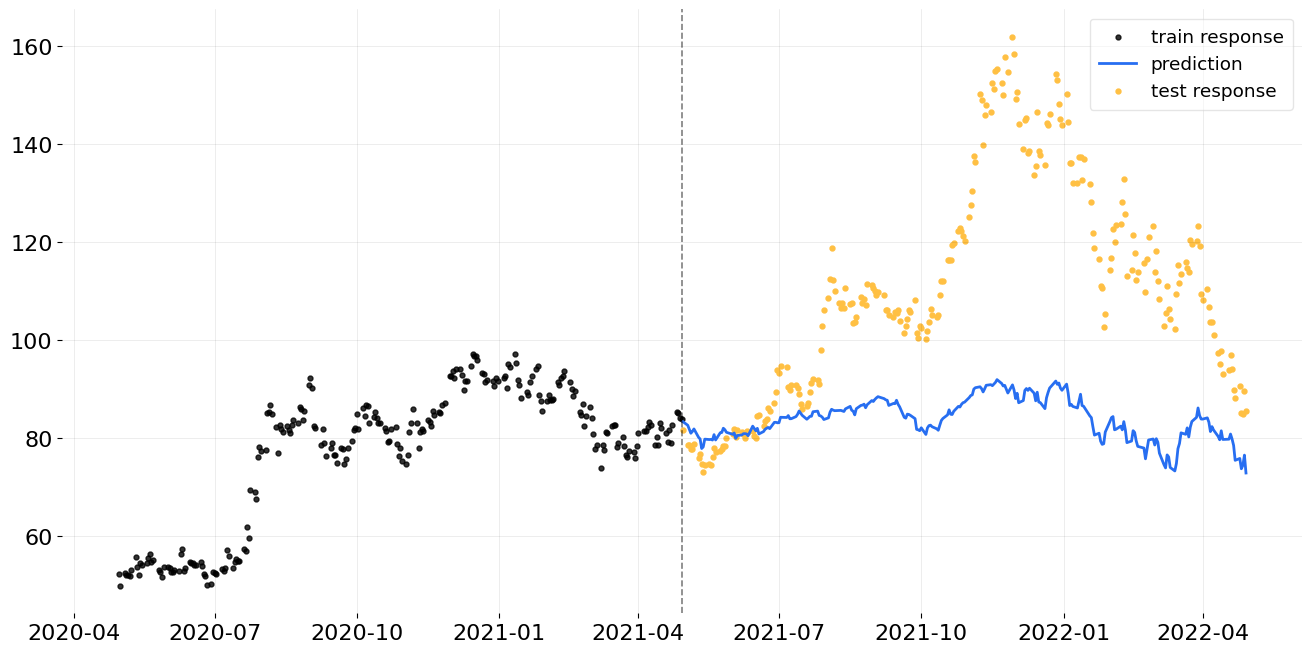

<AxesSubplot:>

In [13]:
plot_predicted_data(
  training_actual_df=stock_price_train, 
  predicted_df=stock_price_predicted, 
  date_col=stock_price_lgt.date_col, 
  actual_col=stock_price_lgt.response_col,
  test_actual_df=stock_price_test
)

In [14]:
stock_price_predicted.tail(10)

,Date,prediction_10,prediction,prediction_90,trend_10,trend,trend_90,seasonality_10,seasonality,seasonality_90,regression_10,regression,regression_90
243,2022-04-18,71.862936,79.798989,105.979839,0.000000,7.726501,33.900148,0.0,0.0,0.0,70.492720,71.745910,72.326578
244,2022-04-19,73.508703,80.844861,109.969613,0.096862,7.899934,36.278880,0.0,0.0,0.0,72.068292,73.349491,73.943138
245,2022-04-20,72.430542,79.838201,110.054356,0.005036,7.232151,38.024416,0.0,0.0,0.0,71.017214,72.279728,72.864716
246,2022-04-21,70.904015,78.528910,108.783525,0.000000,7.441586,37.713223,0.0,0.0,0.0,69.547792,70.784184,71.357068
247,2022-04-22,69.045321,75.487181,105.563062,0.156463,6.699829,36.279632,0.0,0.0,0.0,67.726625,68.930640,69.488523
248,2022-04-25,69.946611,75.863045,106.086694,0.625133,6.319517,36.219203,0.0,0.0,0.0,68.596621,69.816103,70.381152
249,2022-04-26,67.532632,73.764178,105.006473,0.407671,6.722036,37.844214,0.0,0.0,0.0,66.007447,67.180899,67.724621
250,2022-04-27,67.225833,74.467232,104.339647,0.000000,7.185163,37.189856,0.0,0.0,0.0,65.928355,67.100401,67.643471
251,2022-04-28,69.876728,76.546536,106.355774,0.267011,7.123284,36.125821,0.0,0.0,0.0,68.269856,69.483529,70.045887
252,2022-04-29,66.781832,72.900484,102.340258,0.000000,7.132586,35.890627,0.0,0.0,0.0,65.197804,66.356863,66.893916


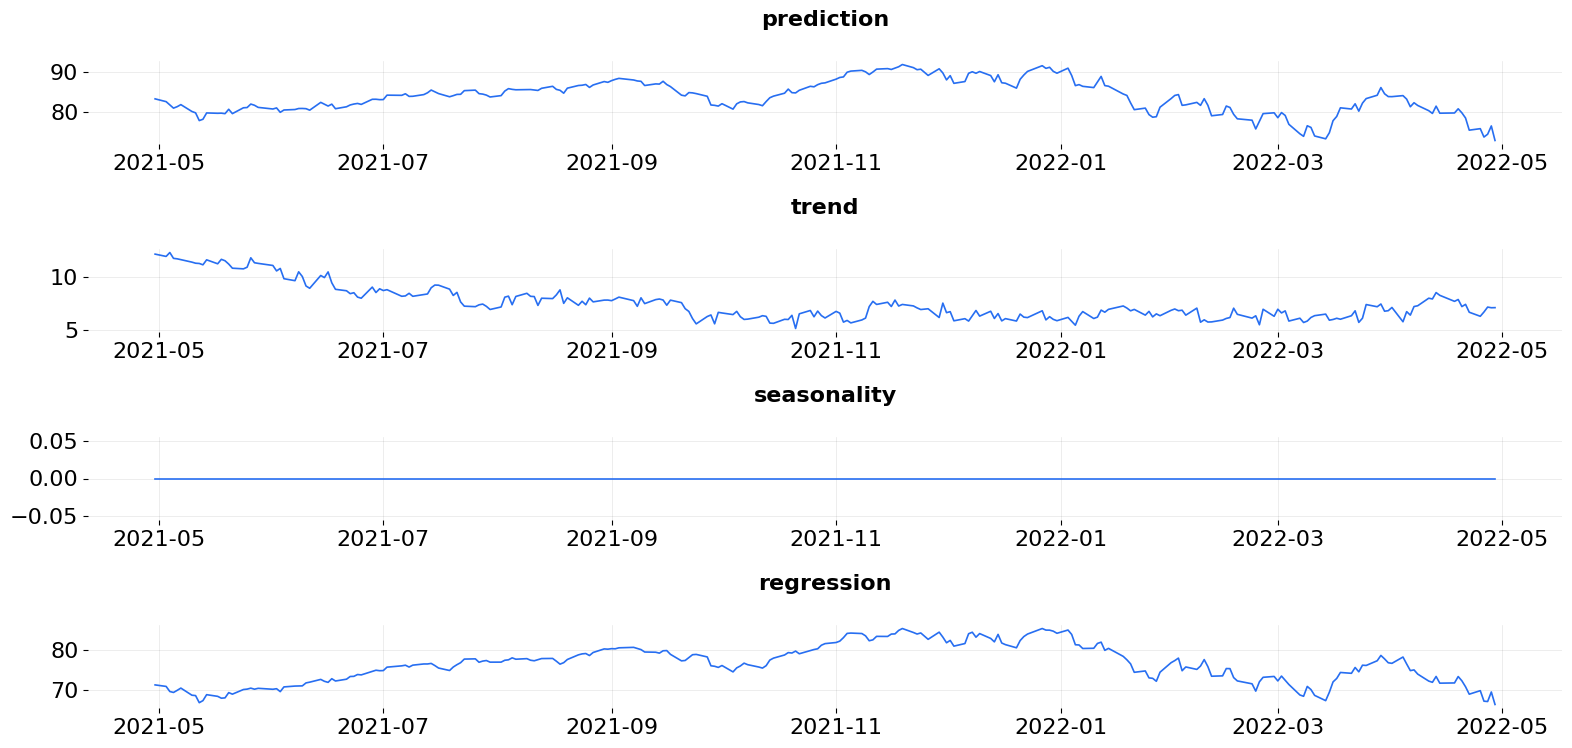

array([<AxesSubplot:title={'center':'prediction'}>,
       <AxesSubplot:title={'center':'trend'}>,
       <AxesSubplot:title={'center':'seasonality'}>,
       <AxesSubplot:title={'center':'regression'}>], dtype=object)

In [15]:
 plot_predicted_components(stock_price_predicted, 
                           date_col='Date',
                           plot_components=['prediction', 'trend', 'seasonality', 'regression'])

### 2.5. Backtest Forecast Model

We know Forecast model will not perform well predicting stock price, but we are not trying to predict the stock price for one year. We are trying to predict stock price for next day.

We have configured the rolling backtest where we train using 10 days of data to predict stock price for 11th. day. Fortunately, Orbit's backtest functionality EXCELS at this.

In [16]:
# configs
min_train_len = 10
forecast_len = 1
incremental_len = 1
window_type = 'rolling'

stock_price_bt = BackTester(
    model=stock_price_lgt,
    df=stock_price,
    min_train_len=min_train_len,
    incremental_len=incremental_len,
    forecast_len=forecast_len,
    window_type=window_type,
)

stock_price_splitter = stock_price_bt.get_splitter()
stock_price_splitter.plot()

<AxesSubplot:title={'center':'Train/Test Split Scheme'}, ylabel='Split #'>

In [17]:
%%time
stock_price_bt.fit_predict()

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 125 and samples(per chain): 250.
INFO:orbit:Sampling (PyStan) with chains: 4, cores: 2, temperature: 1.000, warmups (per chain): 1

CPU times: user 56.9 s, sys: 1min 2s, total: 1min 59s
Wall time: 34min 18s


/usr/local/lib/python3.7/dist-packages/orbit/forecaster/forecaster.py:337: UserWarning: Datetime index is not evenly distributed
  warnings.warn("Datetime index is not evenly distributed")


In [18]:
predicted_df = stock_price_bt.get_predicted_df()
predicted_df.head(5)

,date,actual,prediction_10,prediction,prediction_90,training_data,split_key
0,2020-04-30,52.389999,49.881611,52.433280,55.315218,True,0
1,2020-05-01,49.880001,48.728436,50.996348,53.272952,True,0
2,2020-05-04,52.560001,48.459214,50.862325,53.638910,True,0
3,2020-05-05,52.189999,47.634190,52.272905,54.492433,True,0
4,2020-05-06,52.160000,49.693183,52.330813,54.564998,True,0


/usr/local/lib/python3.7/dist-packages/orbit/diagnostics/plot.py:424: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


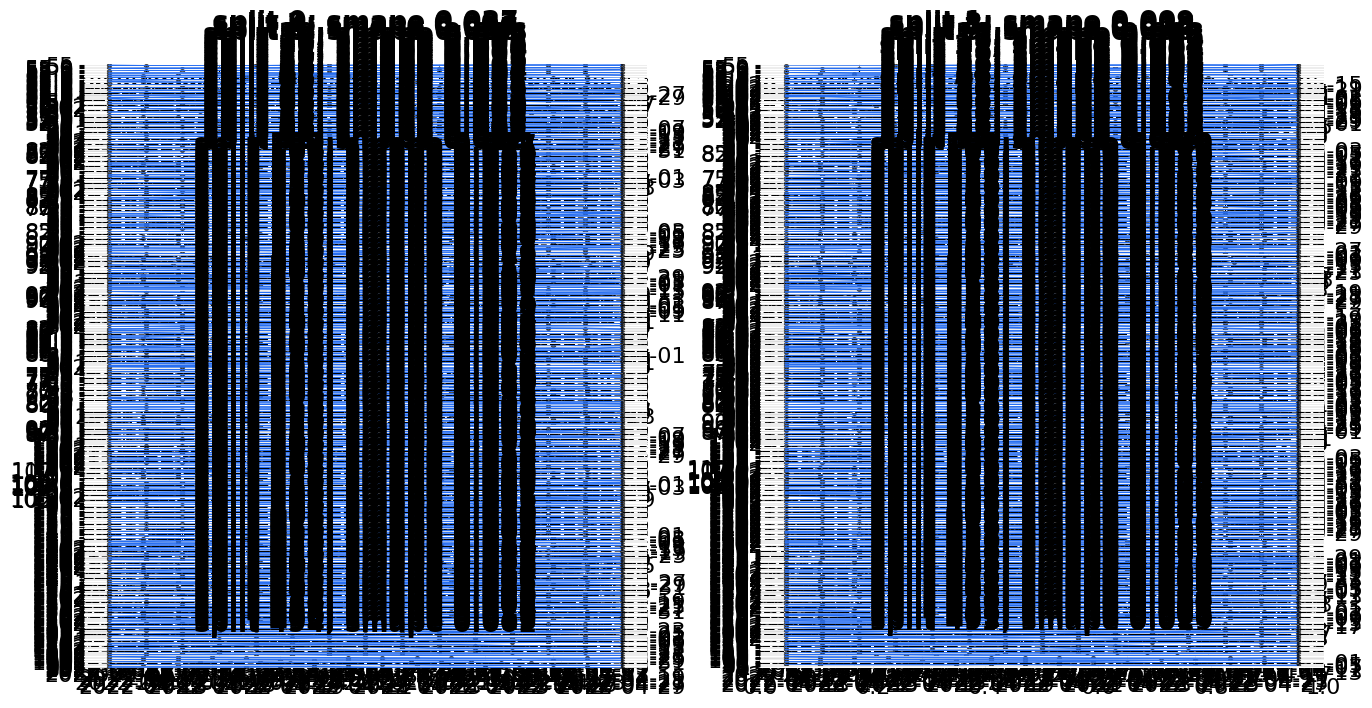

In [19]:
plot_bt_predictions(predicted_df, metrics=smape, ncol=2, include_vline=True);

The forecast model perfomed better than expected with SMAPE of 0.0199. I will try more days in other notebooks.

In [20]:
stock_price_bt.score()

,metric_name,metric_values,is_training_metric
0,smape,0.019948,False
1,wmape,0.020536,False
2,mape,0.019910,False
3,mse,8.043702,False
4,mae,1.943814,False
5,rmsse,0.897524,False


In [21]:
stock_price_predicted.tail(5)

,Date,prediction_10,prediction,prediction_90,trend_10,trend,trend_90,seasonality_10,seasonality,seasonality_90,regression_10,regression,regression_90
248,2022-04-25,69.946611,75.863045,106.086694,0.625133,6.319517,36.219203,0.0,0.0,0.0,68.596621,69.816103,70.381152
249,2022-04-26,67.532632,73.764178,105.006473,0.407671,6.722036,37.844214,0.0,0.0,0.0,66.007447,67.180899,67.724621
250,2022-04-27,67.225833,74.467232,104.339647,0.000000,7.185163,37.189856,0.0,0.0,0.0,65.928355,67.100401,67.643471
251,2022-04-28,69.876728,76.546536,106.355774,0.267011,7.123284,36.125821,0.0,0.0,0.0,68.269856,69.483529,70.045887
252,2022-04-29,66.781832,72.900484,102.340258,0.000000,7.132586,35.890627,0.0,0.0,0.0,65.197804,66.356863,66.893916


In [22]:
predicted_df.tail(20)

,date,actual,prediction_10,prediction,prediction_90,training_data,split_key
5425,2022-04-18,93.889999,90.894512,93.171624,95.134730,True,493
5426,2022-04-19,96.930000,92.420181,95.160025,98.061585,True,493
5427,2022-04-20,94.019997,91.942971,94.673889,97.026584,True,493
5428,2022-04-21,89.849998,90.000057,91.950665,94.119757,True,493
5429,2022-04-22,88.139999,85.643202,88.107667,90.762733,True,493
5430,2022-04-25,90.690002,86.587425,88.989302,91.316839,True,493
5431,2022-04-26,85.160004,84.173138,86.368823,88.589841,True,493
5432,2022-04-27,84.910004,82.753493,85.466763,87.589063,True,493
5433,2022-04-28,89.639999,85.680133,87.922922,90.709795,False,493
5434,2022-04-14,93.059998,90.283184,92.750183,95.712919,True,494
